In [27]:
import matplotlib.pyplot as plt
import numpy as np
import os 
import sys
import json
import torch

sys.path.append("..")
%matplotlib inline

In [38]:
BASE_PATH = "../logs/Mon_Jun__3_00_00_22_2019-9223"
MODEL_BASE_PATH = os.path.join(BASE_PATH, "models")
CONFIG_PATH = os.path.join(BASE_PATH, "config.json")
EPOCH = 1

config = json.load(open(CONFIG_PATH, "rt"))

dataset = config['data']['name']
n_features = config['data'][dataset]['dims']
n_atoms = config['data'][dataset]['atoms']
n_edge_types = config['model']['n_edge_types']
timesteps = config['data']['timesteps']

In [39]:
config

{'globals': {'seed': 42, 'prior': None, 'add_const': False, 'eps': 1e-16},
 'training': {'gpu_id': None,
  'use_early_stopping': True,
  'early_stopping_mode': 'min',
  'early_stopping_metric': 'val_mse_loss',
  'early_stopping_patience': 50,
  'epochs': 10,
  'batch_size': 128,
  'load_path': None,
  'grad_clip_value': None,
  'optimizer': {'type': 'adam',
   'learning_rate': 0.0005,
   'betas': [0.9, 0.999]},
  'scheduler': {'stepsize': 200, 'gamma': 0.5}},
 'data': {'timesteps': 49,
  'name': 'random',
  'path': 'data',
  'random': {'atoms': 4, 'dims': 100, 'examples': 100, 'timesteps': 200},
  'springs': {'suffix': '_springs5', 'atoms': 5, 'dims': 4},
  'weather': {'atoms': 3,
   'dims': 2,
   'examples': 10000,
   'timesteps': 70,
   'force_new': False,
   'discard': False,
   'splits': [72, 14, 14]}},
 'loss': {'beta': 1.0},
 'model': {'prediction_steps': 10,
  'factor_graph': True,
  'skip_first': True,
  'hard': False,
  'dynamic_graph': True,
  'temp': 0.5,
  'burn_in': False,

In [40]:
# Load encoder
from src.model.utils import load_weights, gen_fully_connected
from train import create_encoder

encoder = create_encoder(config)
load_weights(encoder, os.path.join(MODEL_BASE_PATH, f"encoder_epoch{EPOCH}.pt"))

rel_rec, rel_send = gen_fully_connected(n_atoms)

../src/model/modules.py:26: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight.data)
../src/model/modules.py:107: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight.data)


In [41]:
from train import load_data
data_loaders = load_data(config)
test_loader = data_loader['test_loader']

In [42]:
from src.model.utils import gumbel_softmax

data = next(iter(test_loader))[0][:, :, :timesteps, :]

logits = encoder(data, rel_rec, rel_send)
edges = gumbel_softmax(logits, tau=0.5, hard=True)

../src/model/utils.py:79: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  soft_max_1d = F.softmax(trans_input)


In [78]:
from src.model.utils import get_offdiag_indices

n_samples = edges.size(0)
indices = get_offdiag_indices(n_atoms)

graphs = np.empty((n_samples, n_edge_types, n_atoms, n_atoms))
k = None

for sample in range(n_samples):
    for edge_type in range(n_edge_types):
        graph = edges[sample, :, edge_type]
        fully_connected = torch.zeros(n_atoms * n_atoms)
        fully_connected[indices] = graph
        adjacency_matrix = fully_connected.view(n_atoms, n_atoms).detach().numpy()
        graphs[sample, edge_type, :, :] = adjacency_matrix

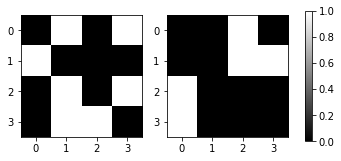

In [94]:
# Plot
SAMPLE = 0

fig, axes = plt.subplots(nrows=1, ncols=n_edge_types)
for i in range(n_edge_types):
    im = axes[i].imshow(graphs[SAMPLE, i, :, :], cmap='gray', interpolation=None)
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)

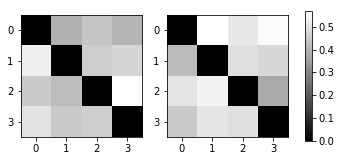

In [95]:
# Averages
fig, axes = plt.subplots(nrows=1, ncols=n_edge_types)
for i in range(n_edge_types):
    im = axes[i].imshow(np.mean(graphs[:, i, :, :], axis=0), cmap='gray', interpolation=None)
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)